# Logistic Regression (applied to dummy data)

In [154]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

# Load data and plot

In [155]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


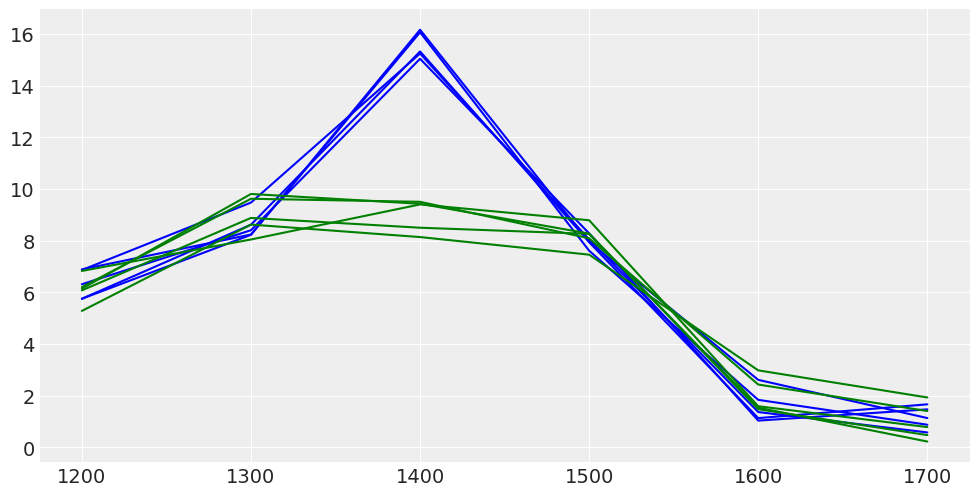

In [156]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [157]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [158]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [159]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

# Model definition (Multiple Linear Regression)

In [160]:
with pm.Model() as model_mlr:
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=Xn.shape[1])
    epsilon = pm.HalfNormal('epsilon', 10)
    
    mu = pm.math.dot(Xn, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:03<00:00, 78.60draws/s] 
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


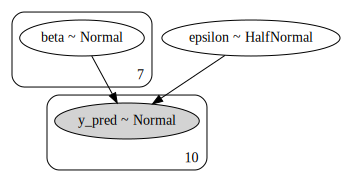

In [161]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [162]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.136,0.499,-0.791,1.033,0.013,0.010,1497.0,1220.0,1503.0,1703.0,1.0
beta[1],0.077,0.153,-0.201,0.376,0.004,0.003,1364.0,1364.0,1391.0,1529.0,1.0
beta[2],0.077,0.096,-0.097,0.262,0.002,0.002,1757.0,1284.0,1692.0,1713.0,1.0
beta[3],-0.137,0.023,-0.180,-0.094,0.001,0.000,1762.0,1762.0,1800.0,1743.0,1.0
beta[4],0.210,0.145,-0.062,0.484,0.004,0.003,1423.0,1164.0,1406.0,1944.0,1.0
beta[5],0.056,0.121,-0.159,0.297,0.003,0.002,1925.0,1285.0,1915.0,1750.0,1.0
beta[6],0.085,0.149,-0.188,0.361,0.003,0.003,1959.0,1469.0,1860.0,1866.0,1.0
epsilon,0.188,0.087,0.089,0.330,0.003,0.002,687.0,687.0,550.0,345.0,1.0


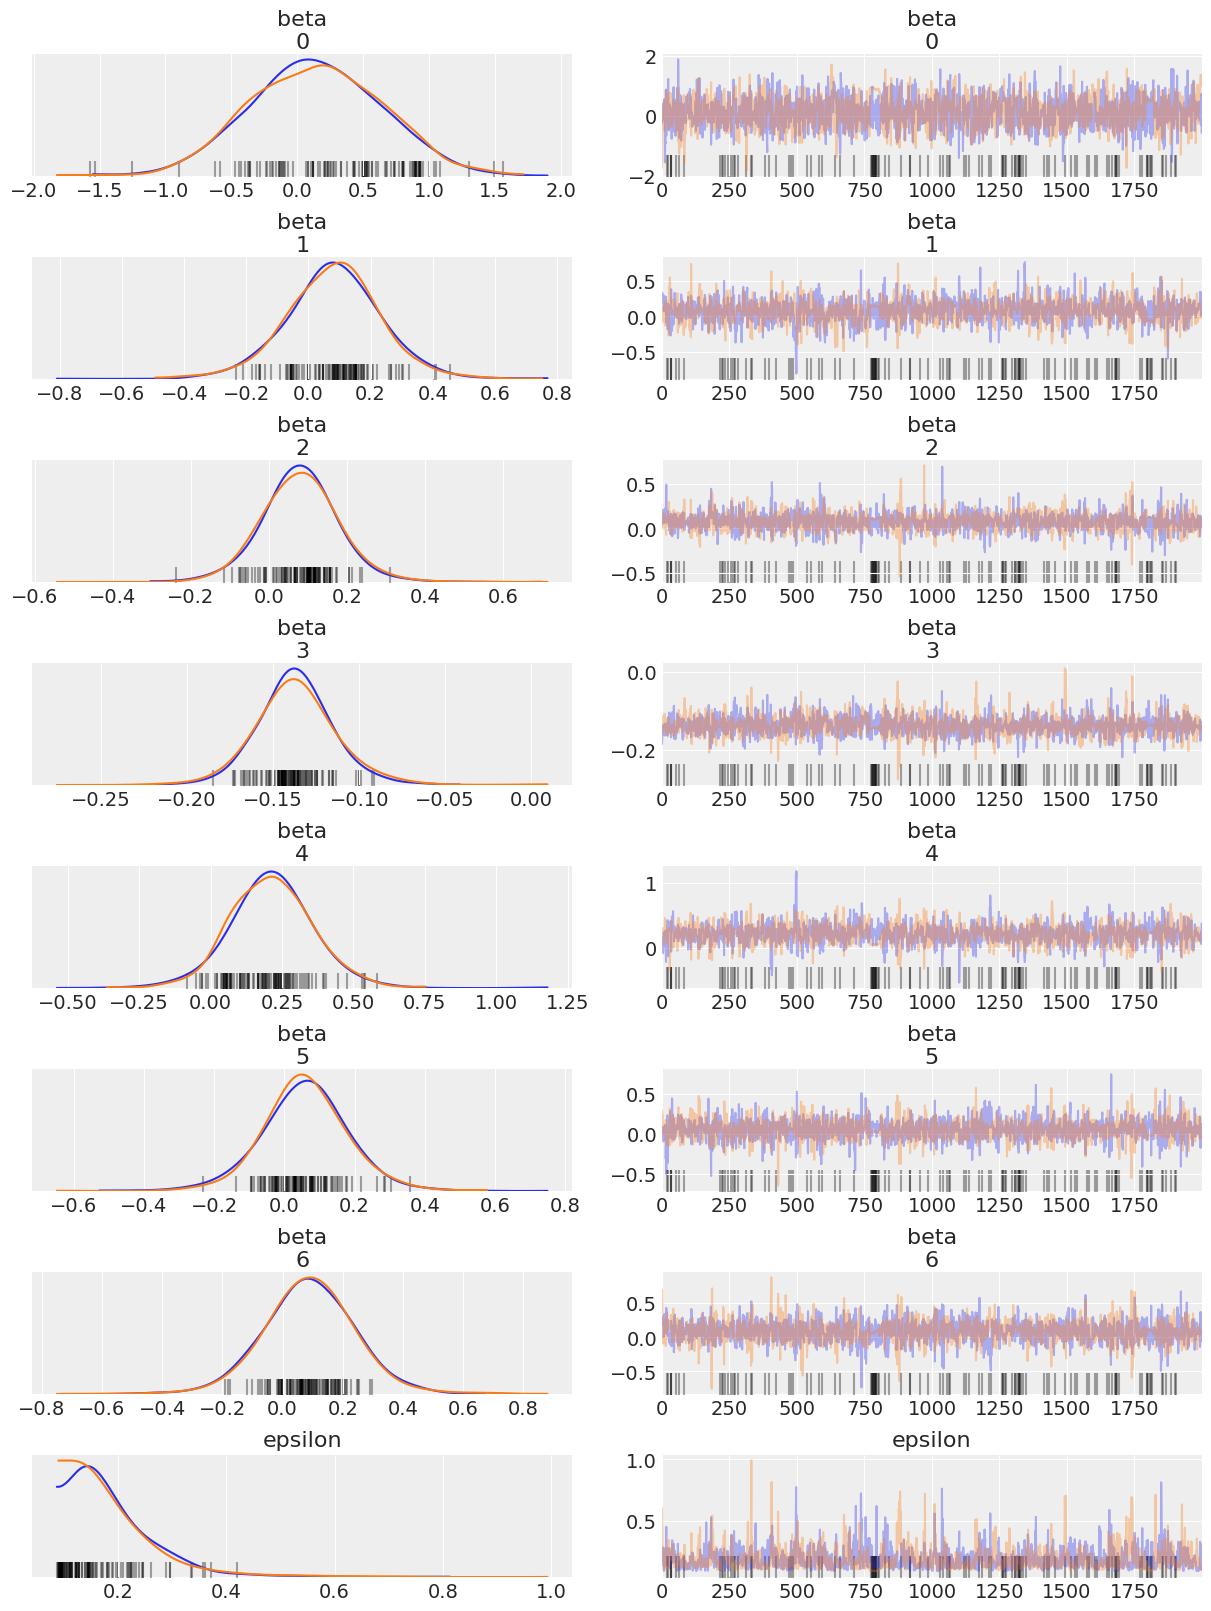

In [163]:
az.plot_trace(trace_mlr);

In [164]:
#az.plot_posterior(trace_mlr);

In [165]:
#az.plot_autocorr(trace_mlr);

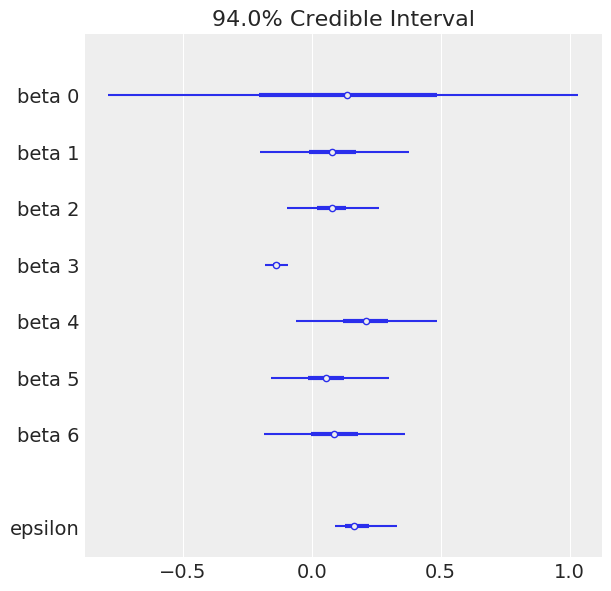

In [166]:
az.plot_forest(trace_mlr, combined=True);

In [167]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=100, model=model_mlr)

100%|██████████| 100/100 [00:00<00:00, 321.29it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


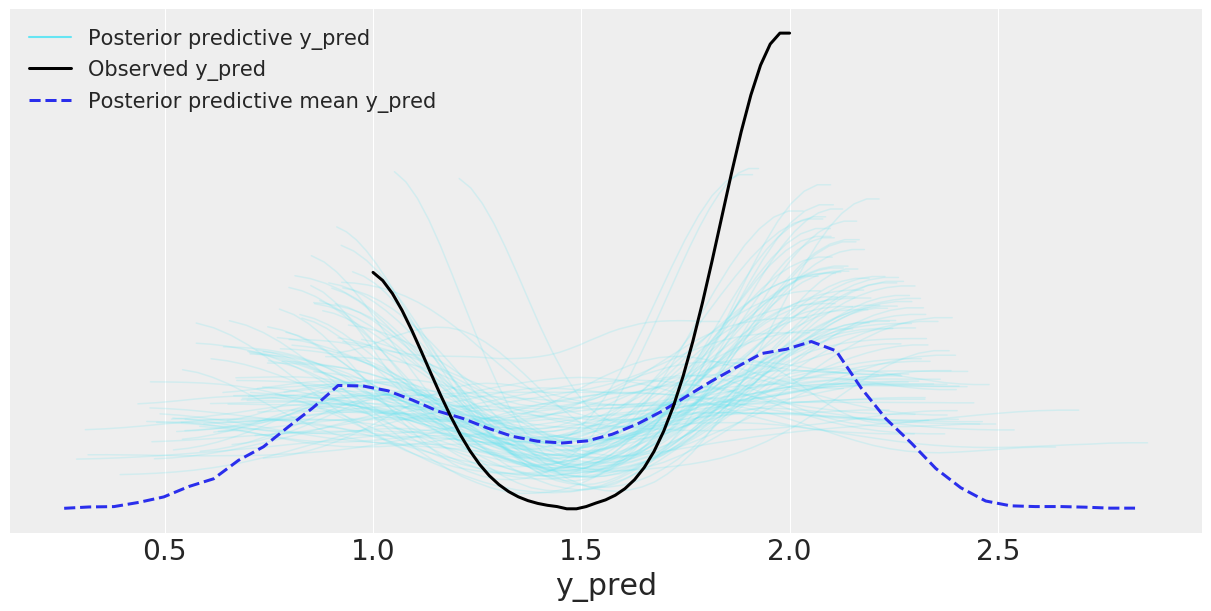

In [168]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

# Model definition (Multiple Logistic Regression)

In [170]:
# extract X and Y data from dataframe
Y = pd.Categorical(data['label']).codes
X = data.iloc[:,:-2]

In [171]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

In [184]:
with pm.Model() as model_lr: 
    beta = pm.Normal('beta', mu=0, sd=10, shape=Xn.shape[1])
    
    mu = pm.math.dot(Xn, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_lr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:59<00:00, 84.17draws/s] 
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


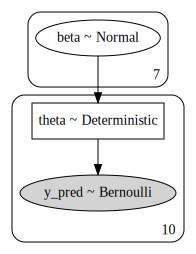

In [185]:
pm.model_to_graphviz(model_lr)

# Model evaluation

In [186]:
varnames = ['beta']
coef = az.summary(trace_lr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.863,9.955,-17.486,19.777,0.244,0.192,1660.0,1340.0,1658.0,1602.0,1.00
beta[1],3.462,8.798,-13.002,19.922,0.267,0.189,1086.0,1086.0,1086.0,1487.0,1.00
beta[2],5.999,7.360,-6.923,20.831,0.209,0.148,1235.0,1235.0,1238.0,1832.0,1.00
beta[3],-11.233,4.616,-19.128,-2.889,0.187,0.132,609.0,609.0,583.0,1011.0,1.01
beta[4],6.755,7.755,-6.654,21.747,0.227,0.161,1171.0,1159.0,1176.0,1665.0,1.00
beta[5],2.143,9.002,-15.148,18.769,0.233,0.165,1487.0,1487.0,1481.0,1829.0,1.00
beta[6],0.837,8.912,-15.001,18.739,0.212,0.161,1759.0,1528.0,1763.0,2081.0,1.00


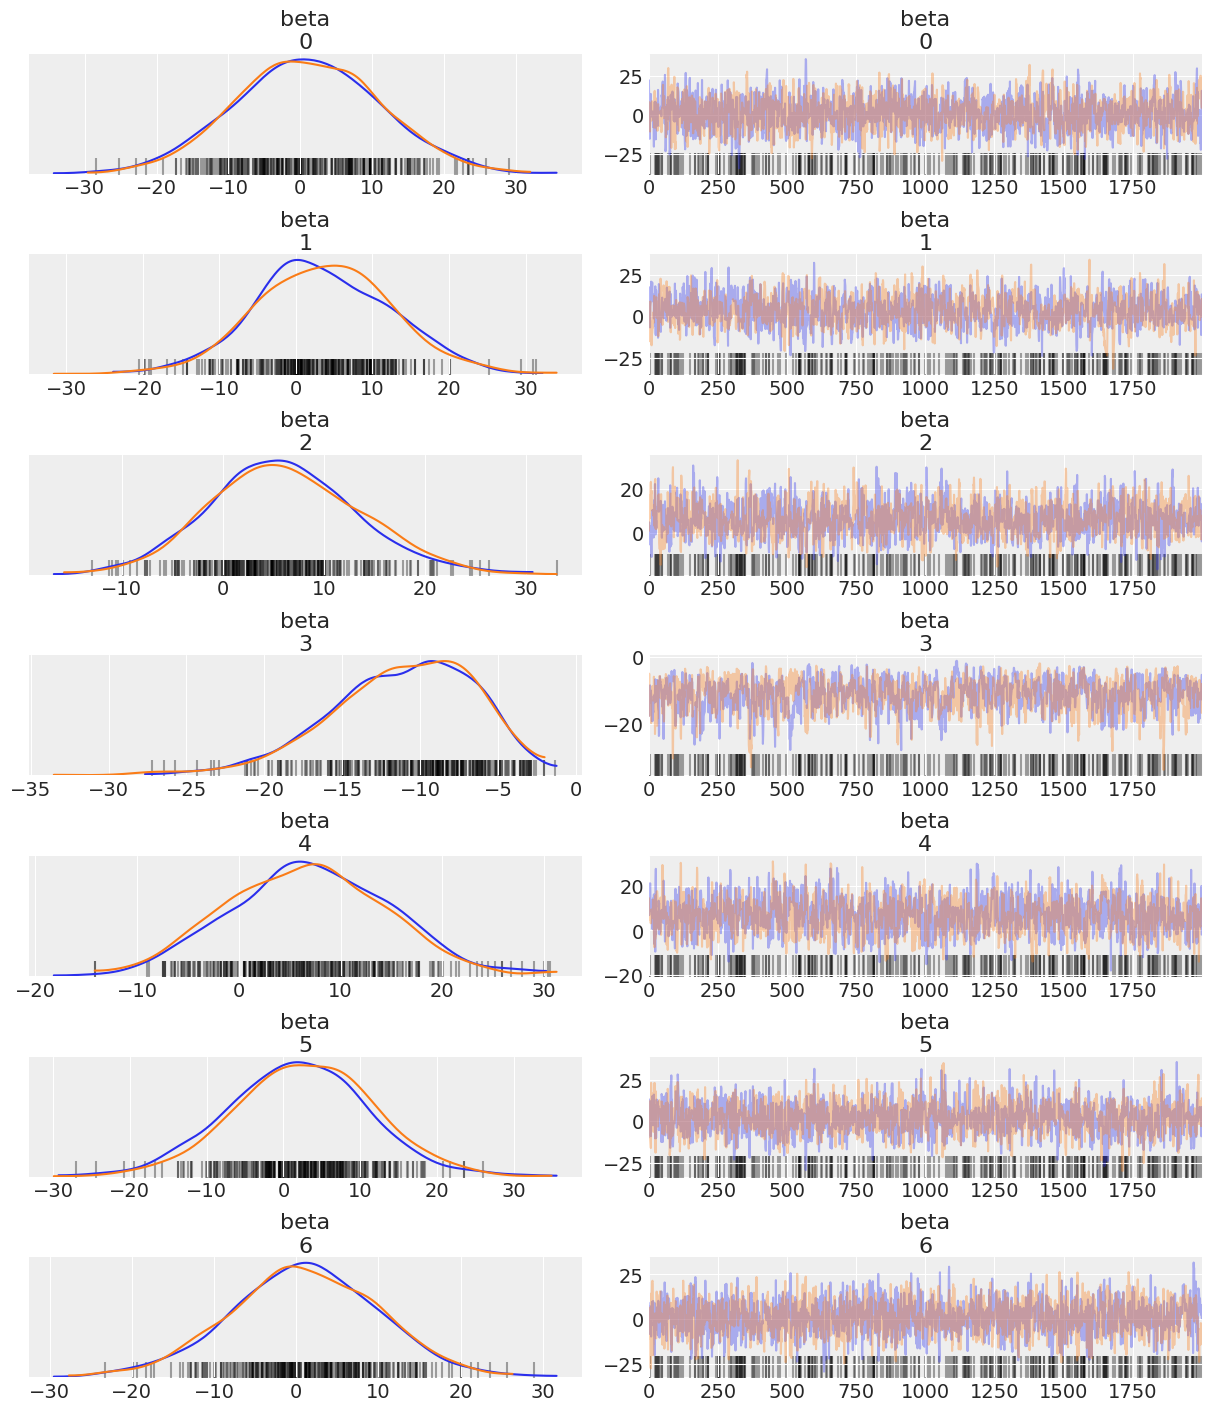

In [187]:
az.plot_trace(trace_lr, varnames);

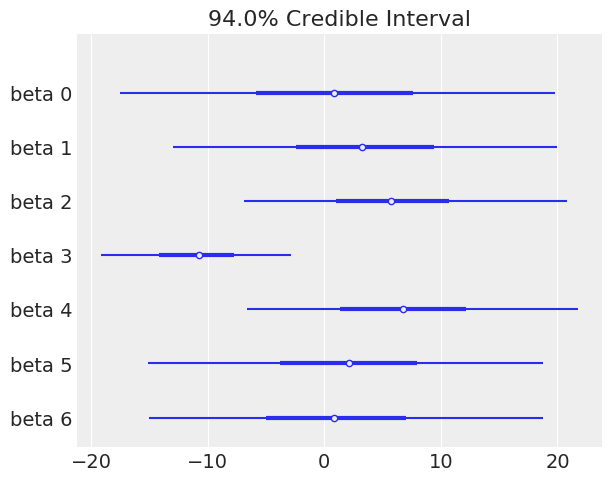

In [188]:
az.plot_forest(trace_lr, var_names=varnames, combined=True);

In [189]:
# check predictions 
from scipy.special import expit as logistic

p_y = np.zeros(len(Xn))
lp = [] 

for i in range(len(Xn)):
    p_y[i] = logistic((coef['mean'] * Xn[i]).sum())
    if (p_y[i] < 0.5): 
        p_y[i] = 0
        lp.append('Arabica')
    else:
        p_y[i] = 1
        lp.append('Robusta')

# add new colums to dataframe
data = data.assign(pred=pd.Series(p_y))
data = data.assign(pred_label=pd.Series(lp))
data

,1200,1300,1400,1500,1600,1700,code,label,pred,pred_label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica,0.0,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica,0.0,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica,0.0,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica,0.0,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica,0.0,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta,1.0,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta,1.0,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta,1.0,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta,1.0,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta,1.0,Robusta
